# Setup

Here, we already imported most of the packages that you might want to use

In [1]:
import os
import pandas as pd

In [2]:
import pm4py

## Log Util
# Log conversion
from pm4py.objects.conversion.log import converter as log_converter
# Read Log (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.util.log import get_event_labels
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter

## Conformance Checking
# Token-based replay (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# Standard Alignments (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.alignments import algorithm as alignments
# Footprint
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

## Petri Nets
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils, check_soundness
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Decision Trees
from sklearn import tree
from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.objects.log.util import get_class_representation

c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\algo\conformance\alignments\algorithm.py:19: UserWarning: please use pm4py.algo.conformance.alignments.petri_net.algorithm instead
  warnings.warn("please use pm4py.algo.conformance.alignments.petri_net.algorithm instead")


# Hints
**Have look at the simplified interface of PM4Py $\rightarrow$ Click on the 'See Simplified Interface' buttons on the documentation page**

Good way to convert a DataFrame so that it works nicely in PM4Py
```python
df = pm4py.format_dataframe(df, case_id=case_id_column activity_key=activity_column, timestamp_key=timestamp_column)
```

If you do not have ipywidgets installed, you'll probably encounter the ```IProgress not found``` error.
In that case, it should help to deactivate the progress bar by passing a dictionary with the following key:
```python
{'show_progress_bar': False}
```
However, currently you can not use the simplified interface then. Instead you have to use the base functions.
For example, for importing a log without progress bar, you can use
```
log = xes_importer.apply('log.xes',parameters={'show_progress_bar':False})
```
If you have ipywidgets installed
```python
log = pm4py.read_xes(file_path)
```
can be used.

In [3]:
log = pm4py.read_xes("logs/log_vaccination.xes")

parsing log, completed traces ::   0%|          | 0/4960 [00:00<?, ?it/s]

# Process Overview

# Process Discovery

 <font size="5">Question 2a</font>

In [4]:
from pm4py.algo.filtering.log.end_activities import end_activities_filter

true_end_activities = ['Checkout No Vacc', 'Decline Vaccination', 'Destroy Vacc', 'Notify about vacc. possibility',
                       'Send Vaccination Certificate']
in_log_end_activities = set(end_activities_filter.get_end_activities(log).keys())
filtered_log = end_activities_filter.apply(log, true_end_activities)

removed_activities = in_log_end_activities - set(true_end_activities)

print(f'Size of original log: {len(log)}')
print(f'Size of filtered log: {len(filtered_log)}')
print(f'Removed end activities: {removed_activities}')

Size of original log: 4960
Size of filtered log: 3444
Removed end activities: {'Priority Appointment granted', 'Checkout', 'Decline vaccination', 'Vaccinate', 'Send Invoice'}


 <font size="5">Question 2b</font>

In [5]:
log_2b = pm4py.read_xes("logs/log_vaccination_finished_cases.xes")
log_2d = pm4py.read_xes("logs/log_vaccination_2c.xes")
from pm4py.objects.petri.importer import importer as petri_net_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/3316 [00:00<?, ?it/s]

c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\objects\petri\__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\objects\petri\obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\objects\petri\exporter\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use the pm4py.objects.petri_net.exporter package instead.')
c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\objects\petri\importer\__init__.py:21:

In [6]:
def fitness_and_precision_calculator(net, initial_marking, final_marking, is2b=True):
    log_to_apply = log_2d
    if is2b:
        log_to_apply = log_2b
    try:
        aligned_traces_IM = alignments.apply_log(log_to_apply, net, initial_marking, final_marking)
        fitness_alignment_IM = replay_fitness.evaluate(aligned_traces_IM, variant=replay_fitness.Variants.ALIGNMENT_BASED)
        precision_alignment_IM = precision_evaluator.apply(log_to_apply, net, initial_marking, final_marking,
                                                           variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
    except:
        fitness_alignment_IM = {'percFitTraces': 0, 'averageFitness': 0, 'percentage_of_fitting_traces': 0, 'average_trace_fitness': 0}
        precision_alignment_IM = 0
    replayed_traces_IM = token_replay.apply(log_to_apply, net, initial_marking, final_marking)
    fitness_token_replay_IM = replay_fitness.evaluate(replayed_traces_IM, variant=replay_fitness.Variants.TOKEN_BASED)
    precision_token_replay_IM = precision_evaluator.apply(log_to_apply, net, initial_marking, final_marking,
                                                          variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

    return {
        'perc_fit_trace (alignment)': fitness_alignment_IM['percentage_of_fitting_traces'],
        'perc_fit_trace (token replay)': fitness_token_replay_IM['percentage_of_fitting_traces'],
        'average_fitness (alignment)': fitness_alignment_IM['average_trace_fitness'],
        'average_fitness (token replay)': fitness_token_replay_IM['average_trace_fitness'],
        'precision (alignment)': precision_alignment_IM,
        'precision (token replay)': precision_token_replay_IM,
    }


def simplicity_and_generalization_calculator(net, initial_marking, final_marking, is2b=True):
    log_to_apply = log_2d
    if is2b:
        log_to_apply = log_2b
    simplicity = simplicity_evaluator.apply(net)
    generalization = generalization_evaluator.apply(log_to_apply, net, initial_marking, final_marking)
    return simplicity, generalization

In [7]:
net_IM, initial_marking_IM, final_marking_IM = petri_net_importer.apply('./pnml/Petri-net-IM.pnml')
net_Alpha, initial_marking_Alpha, final_marking_Alpha = petri_net_importer.apply('./pnml/Petri-net-Alpha.pnml')
net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic = petri_net_importer.apply('./pnml/Petri-net-Heuristic.pnml')
net_ILP, initial_marking_ILP, final_marking_ILP = petri_net_importer.apply('./pnml/Petri-net-ILP.pnml')
net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner = petri_net_importer.apply(
    './pnml/Petri-net-state-region-miner.pnml')

result_IM_2b = fitness_and_precision_calculator(net_IM, initial_marking_IM, final_marking_IM)
result_alpha_2b = fitness_and_precision_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha)
result_heuristic_2b = fitness_and_precision_calculator(net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic)
result_ILP_2b = fitness_and_precision_calculator(net_ILP, initial_marking_ILP, final_marking_ILP)
result_state_region_miner_2b = fitness_and_precision_calculator(net_state_region_miner, initial_marking_state_region_miner,
                                                                final_marking_state_region_miner)



aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

In [8]:
result_fitness_precision_2b = {}

for key in result_IM_2b:
    result_fitness_precision_2b[key] = [result_IM_2b[key]]
for key in result_IM_2b:
    result_fitness_precision_2b[key].append(result_alpha_2b[key])
for key in result_IM_2b:
    result_fitness_precision_2b[key].append(result_heuristic_2b[key])
for key in result_IM_2b:
    result_fitness_precision_2b[key].append(result_ILP_2b[key])
for key in result_IM_2b:
    result_fitness_precision_2b[key].append(result_state_region_miner_2b[key])

df_fitness_precision_2b = pd.DataFrame(result_fitness_precision_2b, index=['IM', 'Alpha', 'Heuristic', 'ILP', 'State Region'])
df_fitness_precision_2b

,perc_fit_trace (alignment),perc_fit_trace (token replay),average_fitness (alignment),average_fitness (token replay),precision (alignment),precision (token replay)
IM,44.947210,44.947210,0.924319,0.936411,0.920100,0.919382
Alpha,0.000000,0.000000,0.000000,0.770813,0.000000,0.399455
Heuristic,1.231775,1.231775,0.802888,0.953413,0.799438,0.799438
ILP,31.171443,31.171443,0.837280,0.927118,0.937179,0.910164
State Region,0.000000,0.000000,0.000000,0.928056,0.000000,0.540627


In [9]:
simplicity_IM, generalization_IM = simplicity_and_generalization_calculator(net_IM, initial_marking_IM, final_marking_IM)
simplicity_alpha, generalization_alpha = simplicity_and_generalization_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha)
simplicity_heuristic, generalization_heuristic = simplicity_and_generalization_calculator(net_Heuristic, initial_marking_Heuristic,
                                                                                          final_marking_Heuristic)
simplicity_ilp, generalization_ilp = simplicity_and_generalization_calculator(net_ILP, initial_marking_ILP, final_marking_ILP)
simplicity_state_region_miner, generalization_state_region_miner = simplicity_and_generalization_calculator(net_state_region_miner,
                                                                                                            initial_marking_state_region_miner,
                                                                                                            final_marking_state_region_miner)

df_simplicity_generalition = pd.DataFrame({
    'simplicity': [simplicity_IM, simplicity_alpha, simplicity_heuristic, simplicity_ilp, simplicity_state_region_miner],
    'generalization': [generalization_IM, generalization_alpha, generalization_heuristic, generalization_ilp,
                       generalization_state_region_miner]
}, index=['IM', 'Alpha', 'Heuristic', 'ILP', 'State Region'])

df_simplicity_generalition

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

,simplicity,generalization
IM,0.795918,0.937063
Alpha,0.398601,0.972661
Heuristic,0.664596,0.932175
ILP,0.271028,0.984557
State Region,0.473684,0.874526


 <font size="5">Question 2c</font>

In [10]:
from pm4py.algo.filtering.log.paths import paths_filter

log_2c1 = paths_filter.apply(log_2b, [('Notify about vacc. possibility', 'Notify about vacc. possibility')], {'positive': False})

In [11]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter

log_2c2 = start_activities_filter.apply(log_2c1, ['Enter into System'])

In [12]:
from pm4py.objects.log.obj import Trace

removed_activities_2c3 = ['Insurance Check Private', 'Insurance Check Statutory', 'Prepare vaccine', 'Send vaccine to cabine',
                          'Send Vaccination Certificate', 'Appointment granted', 'Priority Appointment granted', 'Destroy Vacc',
                          'Send Invoice']

attributes = log_2c2.attributes
extensions = log_2c2.extensions
omni = log_2c2.omni_present
classifiers = log_2c2.classifiers
properties = log_2c2.properties

log_2c3 = EventLog(attributes=attributes, extensions=extensions, omni_present=omni, classifiers=classifiers, properties=properties)

for t in log_2c2:
    trace_attributes = t.attributes
    trace_properties = t.properties
    trace_2c3 = Trace(attributes=attributes, properties=properties)
    for e in t:
        if e['concept:name'] not in removed_activities_2c3:
            trace_2c3.append(e)
    if len(trace_2c3) != 0:
        log_2c3.append(trace_2c3)

In [13]:
for t in log_2c3:
    for e in t:
        if e['concept:name'] == 'Checkout No Vacc':
            e['concept:name'] = 'Decline vaccination'

log_2c4 = log_2c3

In [14]:
activities_set_2c = set()
number_of_event_2c = 0
for t in log_2c4:
    for e in t:
        number_of_event_2c += 1
        activities_set_2c.add(e['concept:name'])

print(f'Number of cases: {len(log_2c4)}')
print(f'Number of events: {number_of_event_2c}')
print(f'Set of activities: {activities_set_2c}')


Number of cases: 3316
Number of events: 37761
Set of activities: {'Notify about vacc. possibility', 'Request appointment', 'Submit Declaration', 'Checkout', 'Decline vaccination', 'Vaccinate', 'Acknowledge vacc. possibility', 'Enter into System', 'Register at vaccination facillity', 'Finished Risk Talk'}


 <font size="5">Question 2d</font>

In [15]:
log_2d = pm4py.read_xes("logs/log_vaccination_2c.xes")

parsing log, completed traces ::   0%|          | 0/3316 [00:00<?, ?it/s]

In [16]:
net_sh, initial_marking_sh, final_marking_sh = petri_net_importer.apply('./models/small_hand.pnml')
net_IM, initial_marking_IM, final_marking_IM = petri_net_importer.apply('./pnml/Petri-net-IM-2d.pnml')
net_Alpha, initial_marking_Alpha, final_marking_Alpha = petri_net_importer.apply('./pnml/Petri-net-Alpha-2d.pnml')
net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic = petri_net_importer.apply('./pnml/Petri-net-Heuristic-2d.pnml')
net_ILP, initial_marking_ILP, final_marking_ILP = petri_net_importer.apply('./pnml/Petri-net-ILP-2d.pnml')
net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner = petri_net_importer.apply(
    './pnml/Petri-net-state-region-miner-2d.pnml')

result_sh_2d = fitness_and_precision_calculator(net_sh, initial_marking_sh, final_marking_sh, False)
result_IM_2d = fitness_and_precision_calculator(net_IM, initial_marking_IM, final_marking_IM, False)
result_alpha_2d = fitness_and_precision_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha, False)
result_heuristic_2d = fitness_and_precision_calculator(net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic, False)
result_ILP_2d = fitness_and_precision_calculator(net_ILP, initial_marking_ILP, final_marking_ILP, False)
result_state_region_miner_2d = fitness_and_precision_calculator(net_state_region_miner, initial_marking_state_region_miner,
                                                                final_marking_state_region_miner, False)

aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

In [17]:
result_fitness_precision_2d = {}

for key in result_sh_2d:
    result_fitness_precision_2d[key] = [result_sh_2d[key]]
for key in result_sh_2d:
    result_fitness_precision_2d[key].append(result_IM_2d[key])
for key in result_sh_2d:
    result_fitness_precision_2d[key].append(result_alpha_2d[key])
for key in result_sh_2d:
    result_fitness_precision_2d[key].append(result_heuristic_2d[key])
for key in result_sh_2d:
    result_fitness_precision_2d[key].append(result_ILP_2d[key])
for key in result_sh_2d:
    result_fitness_precision_2d[key].append(result_state_region_miner_2d[key])

df_fitness_precision_2d = pd.DataFrame(result_fitness_precision_2d, index=['Small Hand', 'IM', 'Alpha', 'Heuristic', 'ILP', 'State Region'])
df_fitness_precision_2d

,perc_fit_trace (alignment),perc_fit_trace (token replay),average_fitness (alignment),average_fitness (token replay),precision (alignment),precision (token replay)
Small Hand,90.138721,90.138721,0.992601,0.992458,0.996637,0.996637
IM,9.529554,9.529554,0.765947,0.759697,0.855878,0.855878
Alpha,0.000000,0.000000,0.000000,0.744245,0.000000,0.448487
Heuristic,0.000000,0.000000,0.000000,0.968322,0.000000,0.947605
ILP,70.717732,70.717732,0.892599,0.936205,0.999364,0.998993
State Region,0.000000,0.000000,0.000000,0.930545,0.000000,0.838200


In [18]:
simplicity_sh, generalization_sh = simplicity_and_generalization_calculator(net_sh, initial_marking_sh, final_marking_sh, False)
simplicity_IM, generalization_IM = simplicity_and_generalization_calculator(net_IM, initial_marking_IM, final_marking_IM, False)
simplicity_alpha, generalization_alpha = simplicity_and_generalization_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha,
                                                                                  False)
simplicity_heuristic, generalization_heuristic = simplicity_and_generalization_calculator(net_Heuristic, initial_marking_Heuristic,
                                                                                          final_marking_Heuristic, False)
simplicity_ilp, generalization_ilp = simplicity_and_generalization_calculator(net_ILP, initial_marking_ILP, final_marking_ILP, False)
simplicity_state_region_miner, generalization_state_region_miner = simplicity_and_generalization_calculator(net_state_region_miner,
                                                                                                            initial_marking_state_region_miner,
                                                                                                            final_marking_state_region_miner,
                                                                                                            False)

df_simplicity_generalition = pd.DataFrame({
    'simplicity': [simplicity_sh, simplicity_IM, simplicity_alpha, simplicity_heuristic, simplicity_ilp, simplicity_state_region_miner],
    'generalization': [generalization_sh, generalization_IM, generalization_alpha, generalization_heuristic, generalization_ilp,
                       generalization_state_region_miner]
}, index=['Small Hand', 'IM', 'Alpha', 'Heuristic', 'ILP', 'State Region'])

df_simplicity_generalition

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

,simplicity,generalization
Small Hand,0.725490,0.959157
IM,0.828571,0.981198
Alpha,0.511111,0.981252
Heuristic,0.694444,0.907697
ILP,0.388889,0.983559
State Region,0.600000,0.868978


 <font size="4">Trace that is modeled by the hand-made model but not the alpha, heuristic, and state-region-based model</font>

In [19]:
replayed_traces_sh = token_replay.apply(log_2d, net_sh, initial_marking_sh, final_marking_sh)
replayed_traces_alpha = token_replay.apply(log_2d, net_Alpha, initial_marking_Alpha, final_marking_Alpha)
replayed_traces_heuristic = token_replay.apply(log_2d, net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic)
replayed_traces_state = token_replay.apply(log_2d, net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner)
for i in range(len(replayed_traces_sh)):
    if replayed_traces_sh[i]['trace_is_fit'] and not replayed_traces_alpha[i]['trace_is_fit'] and not replayed_traces_heuristic[i]['trace_is_fit'] and not replayed_traces_state[i]['trace_is_fit']:
        for e in log_2d[i]:
            print(e['concept:name'])
        break

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Enter into System
Notify about vacc. possibility
Acknowledge vacc. possibility
Request appointment
Register at vaccination facillity
Finished Risk Talk
Submit Declaration
Vaccinate
Checkout
Register at vaccination facillity
Submit Declaration
Vaccinate
Checkout


 <font size="5">Question 2e</font>


In [20]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.inductive.parameters import Parameters as inductive_miner_parameters

net_2e_0, initial_marking_2e_0, final_marking_2e_0 = inductive_miner.apply(log_2b, {inductive_miner_parameters.NOISE_THRESHOLD: 0})
net_2e_1, initial_marking_2e_1, final_marking_2e_1 = inductive_miner.apply(log_2b, {inductive_miner_parameters.NOISE_THRESHOLD: 0.25})
net_2e_2, initial_marking_2e_2, final_marking_2e_2 = inductive_miner.apply(log_2b, {inductive_miner_parameters.NOISE_THRESHOLD: 0.5})
net_2e_3, initial_marking_2e_3, final_marking_2e_3 = inductive_miner.apply(log_2b, {inductive_miner_parameters.NOISE_THRESHOLD: 0.75})

result_2e_0 = fitness_and_precision_calculator(net_2e_0, initial_marking_2e_0, final_marking_2e_0)
result_2e_1 = fitness_and_precision_calculator(net_2e_1, initial_marking_2e_1, final_marking_2e_1)
result_2e_2 = fitness_and_precision_calculator(net_2e_2, initial_marking_2e_2, final_marking_2e_2)
result_2e_3 = fitness_and_precision_calculator(net_2e_3, initial_marking_2e_3, final_marking_2e_3)

c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\algo\discovery\inductive\parameters.py:22: UserWarning: pm4py.algo.discovery.inductive.parameters is deprecated. Please use the variant-specific parameters!
  warnings.warn("pm4py.algo.discovery.inductive.parameters is deprecated. Please use the variant-specific parameters!")


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

In [21]:
result_fitness_precision_2e = {}
for key in result_2e_0:
    result_fitness_precision_2e[key] = [result_sh_2d[key]]
for key in result_2e_0:
    result_fitness_precision_2e[key].append(result_2e_1[key])
for key in result_2e_0:
    result_fitness_precision_2e[key].append(result_2e_2[key])
for key in result_2e_0:
    result_fitness_precision_2e[key].append(result_2e_3[key])

df_fitness_precision_2e = pd.DataFrame(result_fitness_precision_2e, index=['0', '0.25', '0.5', '0.75'])
df_fitness_precision_2e

,perc_fit_trace (alignment),perc_fit_trace (token replay),average_fitness (alignment),average_fitness (token replay),precision (alignment),precision (token replay)
0,90.138721,90.138721,0.992601,0.992458,0.996637,0.996637
0.25,100.000000,100.000000,1.000000,1.000000,0.168759,0.168759
0.5,100.000000,100.000000,1.000000,1.000000,0.168759,0.168759
0.75,100.000000,100.000000,1.000000,1.000000,0.168759,0.168759


In [22]:
simplicity_2e_0, generalization_2e_0 = simplicity_and_generalization_calculator(net_2e_0, initial_marking_2e_0, final_marking_2e_0)
simplicity_2e_1, generalization_2e_1 = simplicity_and_generalization_calculator(net_2e_1, initial_marking_2e_1, final_marking_2e_1)
simplicity_2e_2, generalization_2e_2 = simplicity_and_generalization_calculator(net_2e_2, initial_marking_2e_2, final_marking_2e_2)
simplicity_2e_3, generalization_2e_3 = simplicity_and_generalization_calculator(net_2e_3, initial_marking_2e_3, final_marking_2e_3)

df_simplicity_generalition = pd.DataFrame({
    'simplicity': [simplicity_2e_0, simplicity_2e_1, simplicity_2e_2, simplicity_2e_3],
    'generalization': [generalization_2e_0, generalization_2e_1, generalization_2e_2, generalization_2e_3]
}, index=['0', '0.25', '0.5', '0.75'])

df_simplicity_generalition

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

,simplicity,generalization
0,0.616438,0.958559
0.25,0.616438,0.958559
0.5,0.616438,0.958559
0.75,0.616438,0.958559


# Conformance Checking

In [23]:
from pm4py.algo.conformance.footprints.util import evaluation as fp_evaluation
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness

# Prepare the log
log_finished_cases = pm4py.read_xes("logs/log_vaccination_finished_cases.xes")

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

# Question 3a

In [24]:
import pm4py.visualization.footprints.visualizer as fp_visualizer

# Import the model of inductive and heuristic miner
pn_inductive, im_inductive, fm_inductive = pnml_importer.apply("pnml/Petri-net-IM.pnml")
pn_heuristic, im_heuristic, fm_heuristic = pnml_importer.apply("pnml/Petri-net-Heuristic.pnml")

The inductive miner model:


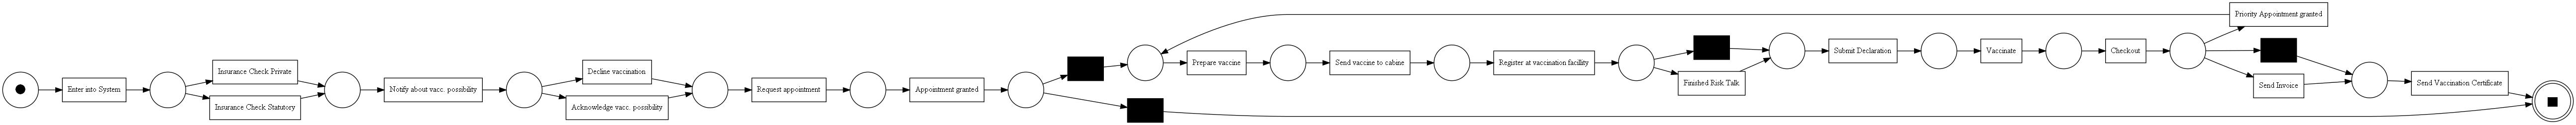

The heuristic miner model:


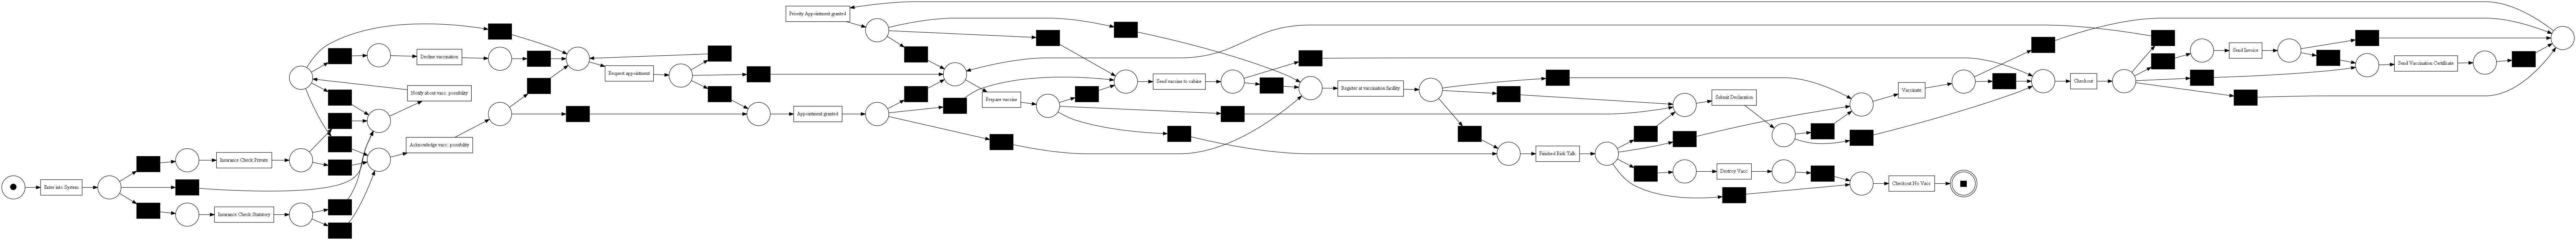

The footprints matrix of the inductive miner model:


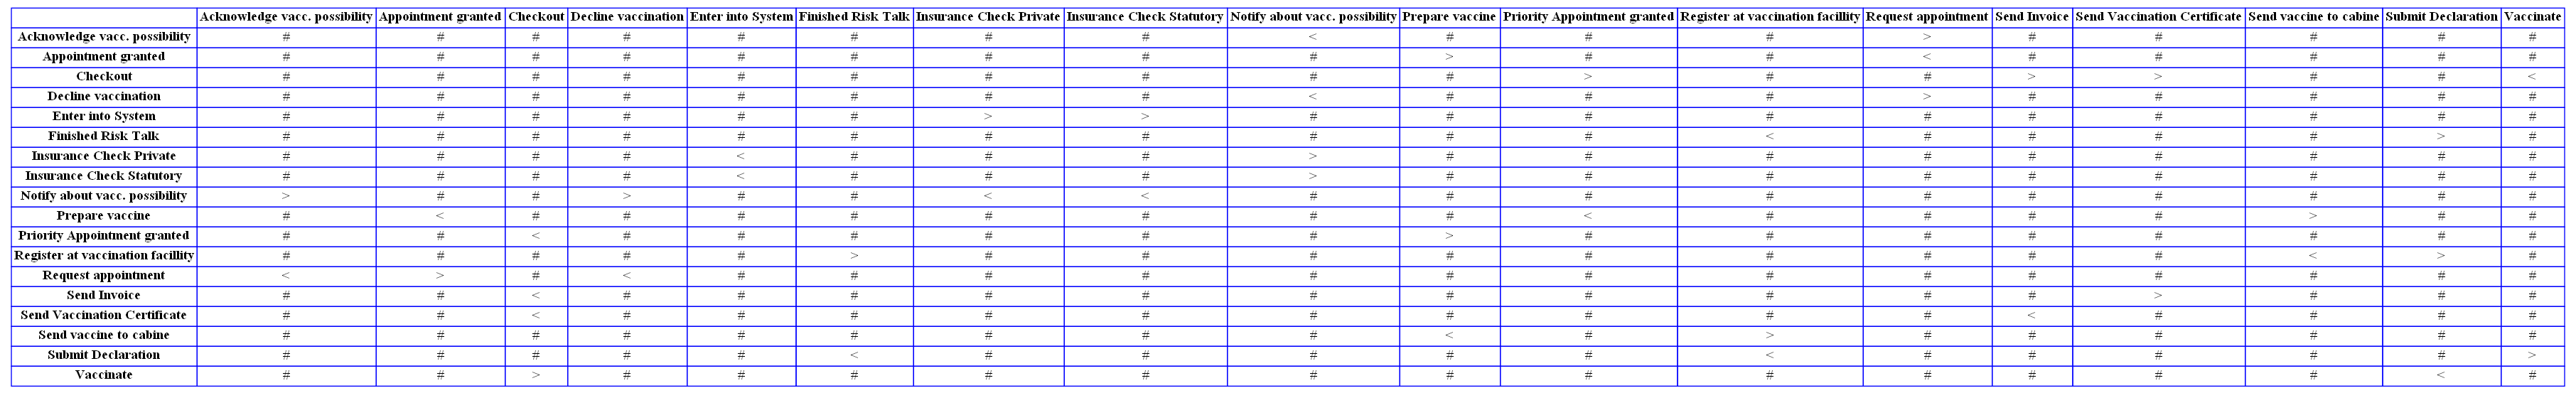

The footprints matrix of the heuristic miner model:


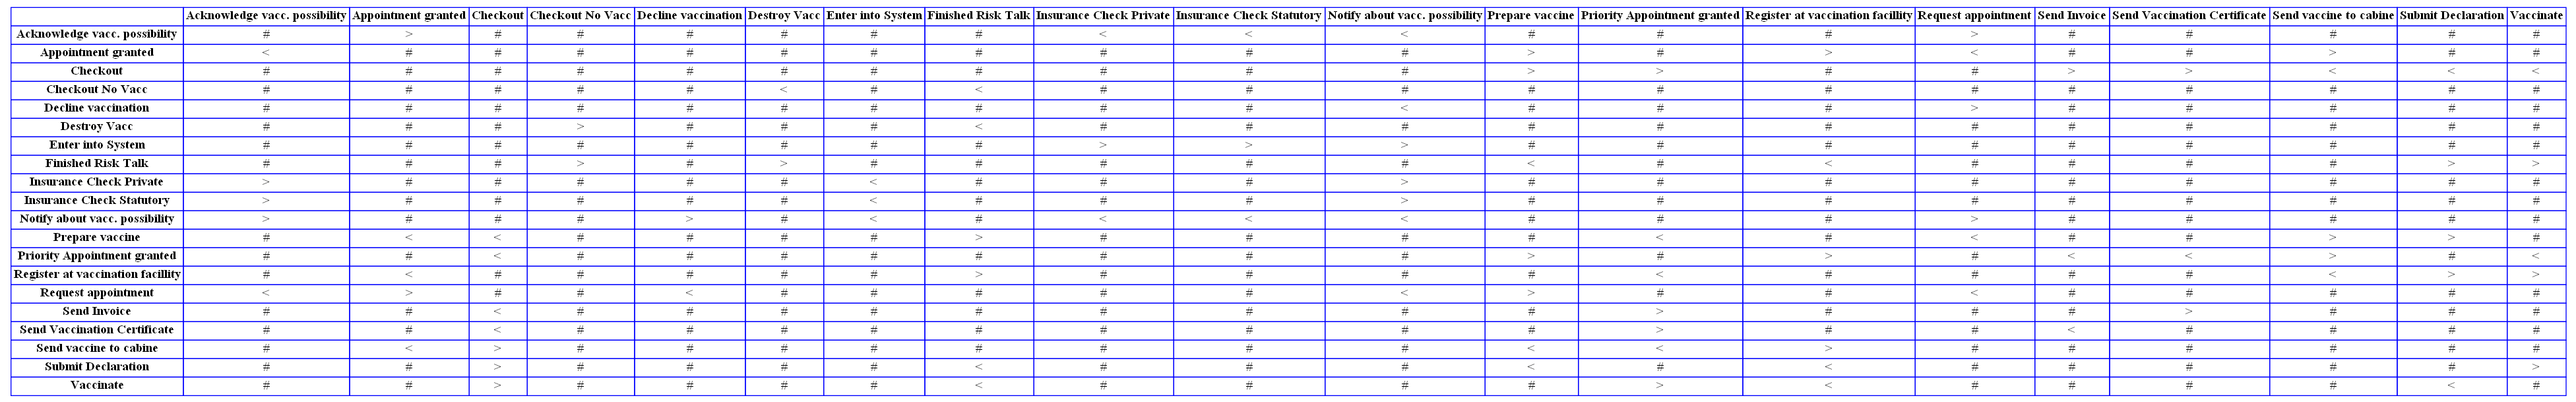

{'sequence': {('Vaccinate', 'Checkout'), ('Insurance Check Private', 'Notify about vacc. possibility'), ('Request appointment', 'Appointment granted'), ('Acknowledge vacc. possibility', 'Request appointment'), ('Checkout', 'Priority Appointment granted'), ('Submit Declaration', 'Vaccinate'), ('Finished Risk Talk', 'Submit Declaration'), ('Prepare vaccine', 'Send vaccine to cabine'), ('Notify about vacc. possibility', 'Acknowledge vacc. possibility'), ('Notify about vacc. possibility', 'Decline vaccination'), ('Register at vaccination facillity', 'Finished Risk Talk'), ('Send vaccine to cabine', 'Register at vaccination facillity'), ('Checkout', 'Send Invoice'), ('Enter into System', 'Insurance Check Private'), ('Priority Appointment granted', 'Prepare vaccine'), ('Appointment granted', 'Prepare vaccine'), ('Enter into System', 'Insurance Check Statutory'), ('Register at vaccination facillity', 'Submit Declaration'), ('Send Invoice', 'Send Vaccination Certificate'), ('Insurance Check St

In [25]:
fp_inductive = footprints_discovery.apply(pn_inductive, im_inductive, fm_inductive)
fp_heuristic = footprints_discovery.apply(pn_heuristic, im_heuristic, fm_heuristic)

print("The inductive miner model:")
gviz = pn_visualizer.apply(pn_inductive, im_inductive, fm_inductive)
pn_visualizer.view(gviz)

print("The heuristic miner model:")
gviz = pn_visualizer.apply(pn_heuristic, im_heuristic, fm_heuristic)
pn_visualizer.view(gviz)

print("The footprints matrix of the inductive miner model:")
gviz = fp_visualizer.apply(fp_inductive)
fp_visualizer.view(gviz)

print("The footprints matrix of the heuristic miner model:")
gviz = fp_visualizer.apply(fp_heuristic)
fp_visualizer.view(gviz)

print(fp_inductive)
print(fp_heuristic)
print(
    f"The inductive miner model has {len(fp_inductive['sequence'])} sequence contructs and {len(fp_inductive['parallel'])} parallel constructs")
print(
    f"The heuristic miner model has {len(fp_heuristic['sequence'])} sequence contructs and {len(fp_heuristic['parallel'])} parallel constructs")

# Question 3b

In [26]:
# Import the full hand model
pn_full_hand, im_full_hand, fm_full_hand = pnml_importer.apply("models/full_hand.pnml")

In [27]:
# Helper functions to calculate conformance
def calculate_conformance(algo, log, pn, im, fm):
    return algo(log, pn, im, fm)


# Calculate footprints conformance
# UNRELIABLE FUNCTION, PM4PY BUGGED
def fp_conformance(log, pn, im, fm):
    fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
    fp_pn = footprints_discovery.apply(pn, im, fm)
    fp_res = footprints_conformance.apply(fp_log, fp_pn, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
    fp_fitness = fp_evaluation.fp_fitness(fp_log, fp_pn, fp_res)
    print(f"The fitness of the model according to footprint matrix is {fp_fitness}")
    return fp_fitness


# Calculate token-based replay conformance
def tbr_conformance(log, pn, im, fm):
    # Replaying traces
    replayed_traces = token_replay.apply(log, pn, im, fm)

    # Calculating the total number of misisng, consumed, remaining, producde tokens
    m, c, r, p = 0, 0, 0, 0
    for res in replayed_traces:
        m += res['missing_tokens']
        c += res['consumed_tokens']
        r += res['remaining_tokens']
        p += res['produced_tokens']

    # Final result as log fitness
    tbr_fitness = 0.5 * (1 - m / c) + 0.5 * (1 - r / p)
    print(f"The fitness of the model according to token-based replay is {tbr_fitness}")

    return tbr_fitness


# Calculate alignments-based conformance
def alignments_conformance(log, pn, im, fm):
    aligned_traces = alignments.apply_log(log, pn, im, fm)
    alignments_fitness = replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED)['log_fitness']
    print(f"The fitness of the model according to alignments is {alignments_fitness}")
    return alignments_fitness

In [28]:
# Footprints conformance
calculate_conformance(fp_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to footprint matrix is 0.9047722487656111


0.9047722487656111

In [29]:
# Token-based replay
calculate_conformance(tbr_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to token-based replay is 0.9695556239672888


0.9695556239672888

In [30]:
# Alignments
calculate_conformance(alignments_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9598597978930206


0.9598597978930206

# Question 3c

In [31]:
# Import the logs and the models
log_one_trace = xes_importer.apply("logs/one_trace_log.xes")
pn_flower, im_flower, fm_flower = pnml_importer.apply("models/flower.pnml")

parsing log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# Log of finished cases and the flower model
calculate_conformance(fp_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)
calculate_conformance(alignments_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)

The fitness of the model according to footprint matrix is 1.0


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9999890530526768


0.9999890530526768

In [33]:
# One-trace log and the full hand model
calculate_conformance(tbr_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
calculate_conformance(alignments_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to token-based replay is 0.9333333333333333
The fitness of the model according to alignments is 0.6206853745836236


0.6206853745836236

In [34]:
# Viewing the alignment of the one-trace log
one_trace_align = alignments.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
one_trace_align

[{'alignment': [('Enter into System', 'Enter into System'),
   ('Insurance Check Statutory', 'Insurance Check Statutory'),
   ('Notify about vacc. possibility', 'Notify about vacc. possibility'),
   ('Acknowledge vacc. possibility', 'Acknowledge vacc. possibility'),
   ('Acknowledge vacc. possibility', '>>'),
   ('Request appointment', 'Request appointment'),
   ('Request appointment', '>>'),
   ('Appointment granted', 'Appointment granted'),
   ('Appointment granted', '>>'),
   ('Prepare vaccine', 'Prepare vaccine'),
   ('Prepare vaccine', '>>'),
   ('Send vaccine to cabine', 'Send vaccine to cabine'),
   ('Send vaccine to cabine', '>>'),
   ('Register at vaccination facillity', 'Register at vaccination facillity'),
   ('Register at vaccination facillity', '>>'),
   ('Finished Risk Talk', '>>'),
   ('Finished Risk Talk', 'Finished Risk Talk'),
   ('>>', None),
   ('Submit Declaration', 'Submit Declaration'),
   ('Submit Declaration', '>>'),
   ('Vaccinate', 'Vaccinate'),
   ('Vaccinat

In [35]:
# Viewing the token based replay of the one-trace log
tokens = token_replay.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
tokens

[{'trace_is_fit': False,
  'trace_fitness': 0.9333333333333333,
  'activated_transitions': [(n26, 'Enter into System'),
   (n28, 'Insurance Check Statutory'),
   (n29, 'Notify about vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n32, 'Request appointment'),
   (n32, 'Request appointment'),
   (n33, 'Appointment granted'),
   (n33, 'Appointment granted'),
   (n34, 'Prepare vaccine'),
   (n34, 'Prepare vaccine'),
   (n35, 'Send vaccine to cabine'),
   (n35, 'Send vaccine to cabine'),
   (n36, 'Register at vaccination facillity'),
   (n36, 'Register at vaccination facillity'),
   (n38, 'Finished Risk Talk'),
   (n38, 'Finished Risk Talk'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n40, 'Vaccinate'),
   (n40, 'Vaccinate'),
   (n41, 'Checkout'),
   (n41, 'Checkout'),
   (n43, None),
   (n45, 'Send Vaccination Certificate'),
   (n45, 'Send Vaccination Certificate')],
  'r

# Question 3a

In [36]:
import pm4py.visualization.footprints.visualizer as fp_visualizer

# Import the model of inductive and heuristic miner
pn_inductive, im_inductive, fm_inductive = pnml_importer.apply("pnml/Petri-net-IM.pnml")
pn_heuristic, im_heuristic, fm_heuristic = pnml_importer.apply("pnml/Petri-net-Heuristic.pnml")

The inductive miner model:


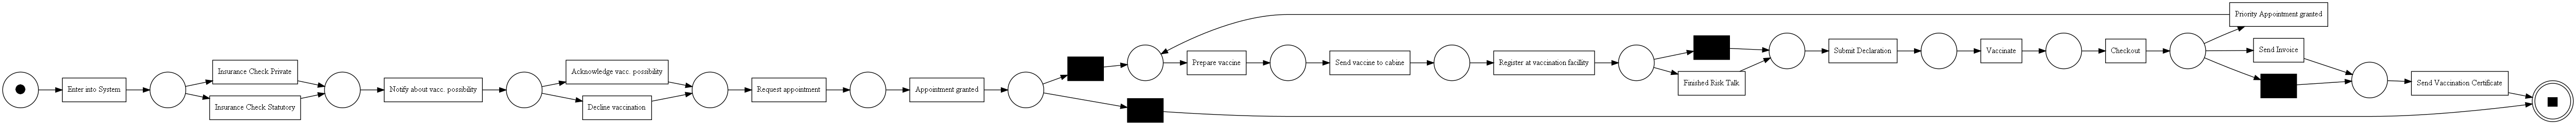

The heuristic miner model:


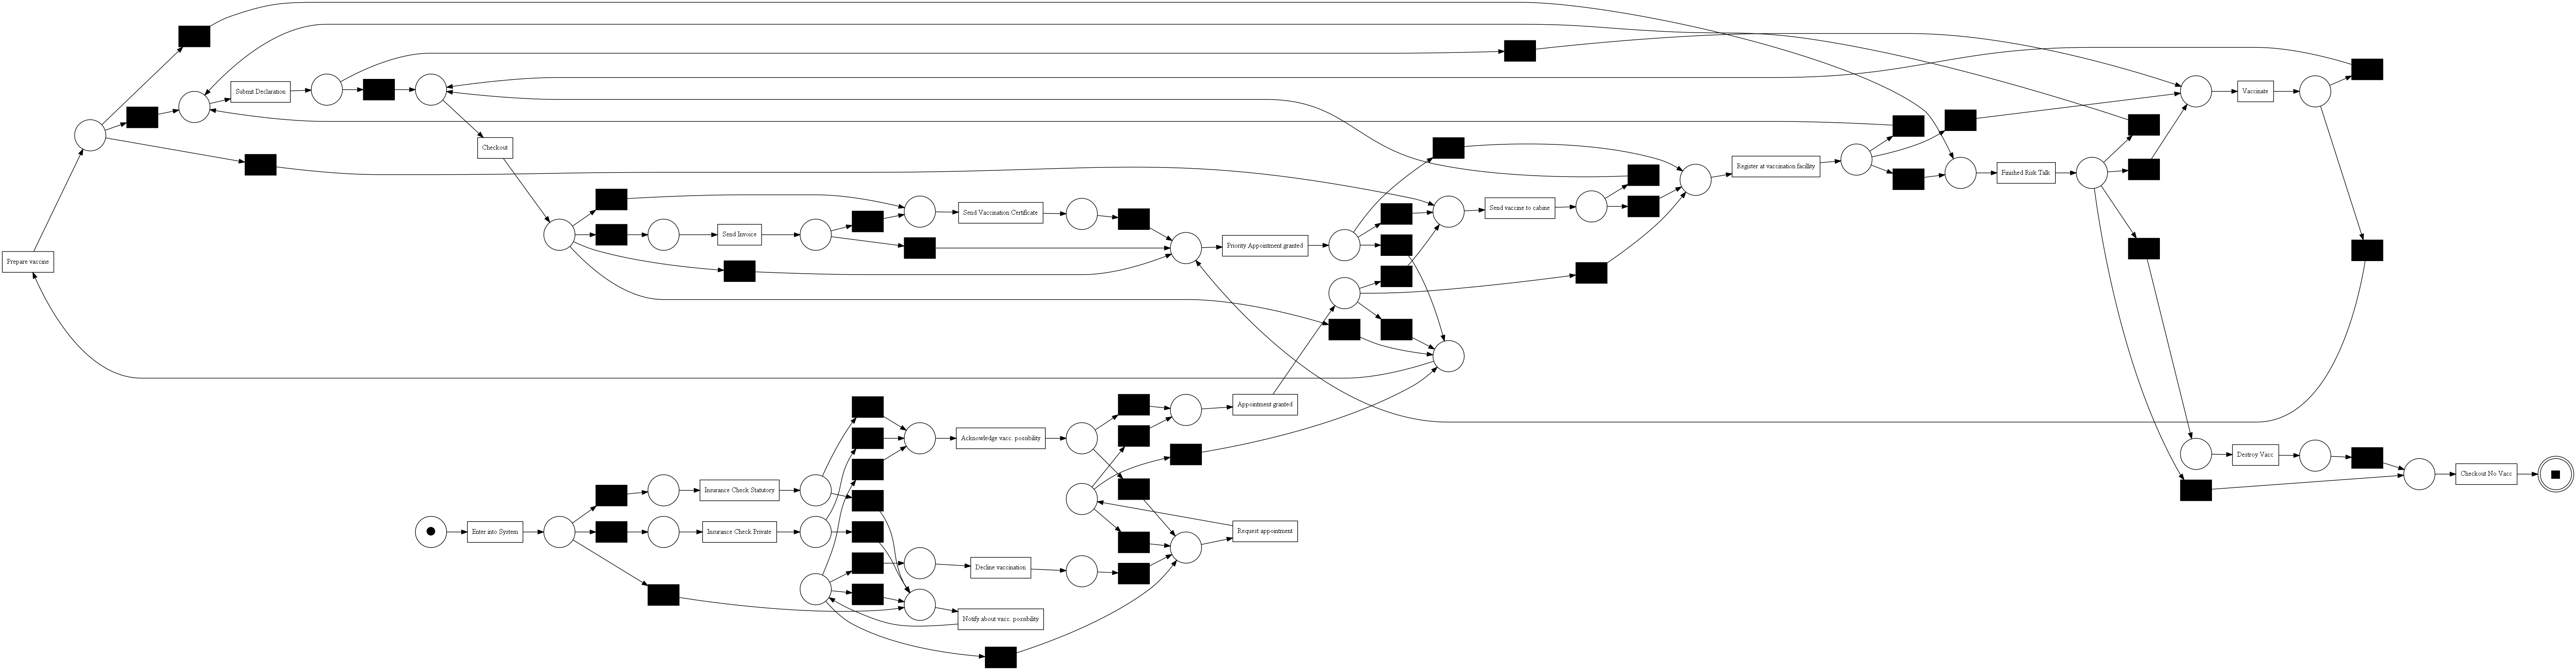

The footprints matrix of the inductive miner model:


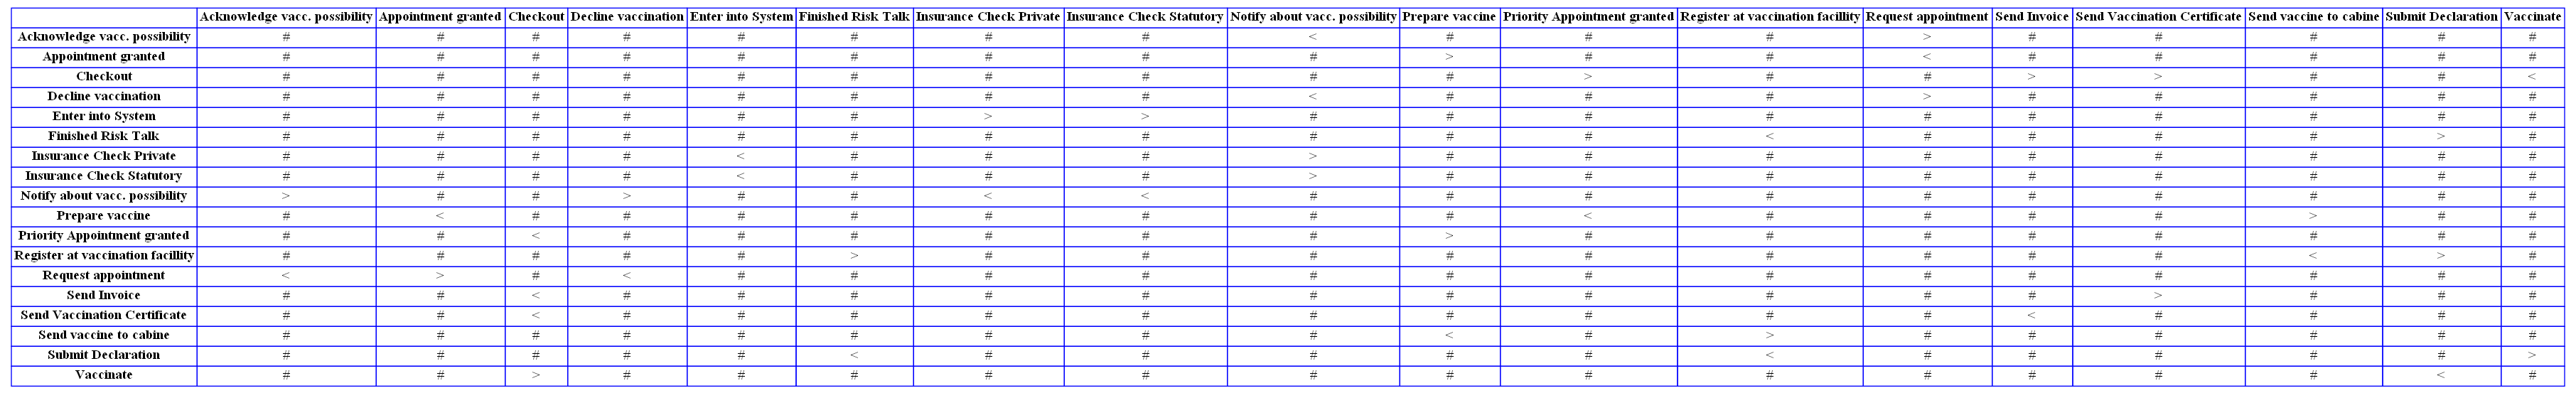

The footprints matrix of the heuristic miner model:


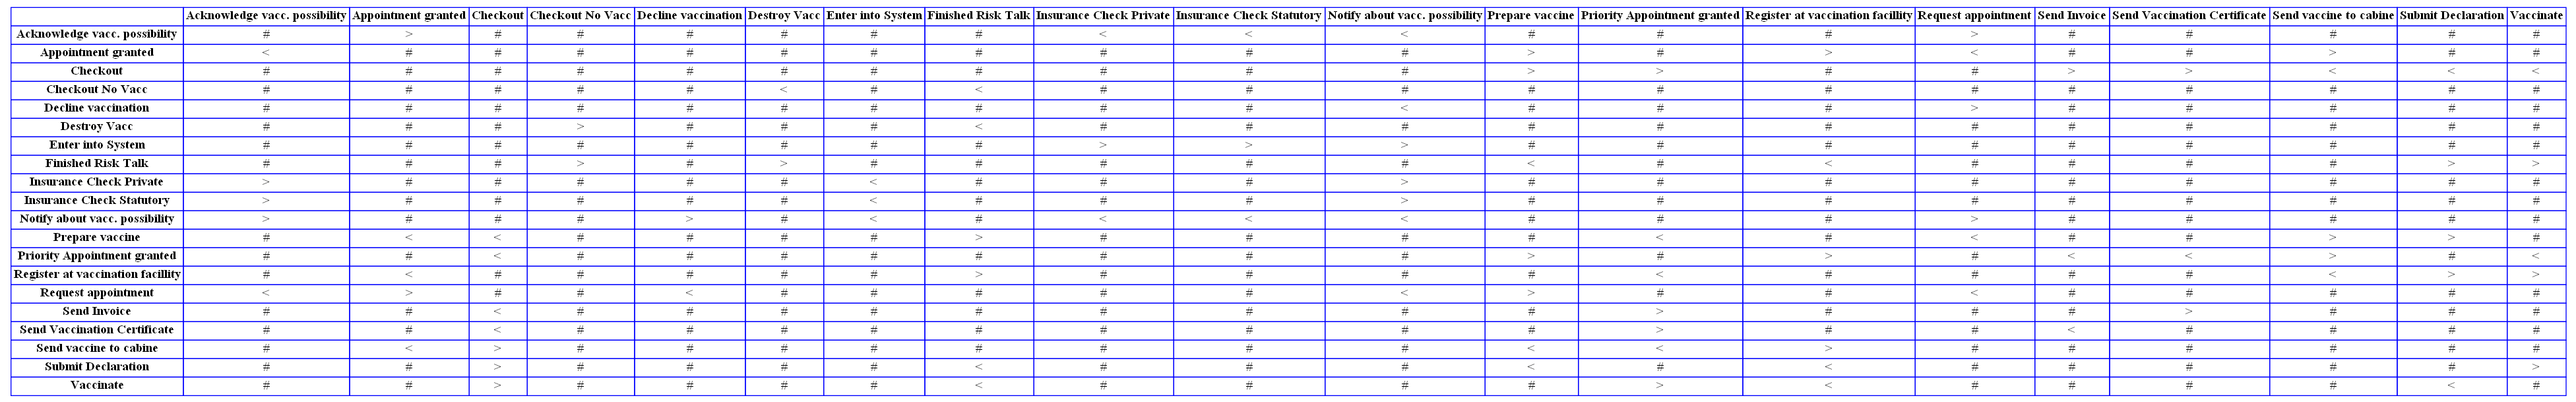

{'sequence': {('Vaccinate', 'Checkout'), ('Insurance Check Private', 'Notify about vacc. possibility'), ('Request appointment', 'Appointment granted'), ('Acknowledge vacc. possibility', 'Request appointment'), ('Checkout', 'Priority Appointment granted'), ('Submit Declaration', 'Vaccinate'), ('Finished Risk Talk', 'Submit Declaration'), ('Prepare vaccine', 'Send vaccine to cabine'), ('Notify about vacc. possibility', 'Acknowledge vacc. possibility'), ('Notify about vacc. possibility', 'Decline vaccination'), ('Register at vaccination facillity', 'Finished Risk Talk'), ('Send vaccine to cabine', 'Register at vaccination facillity'), ('Checkout', 'Send Invoice'), ('Enter into System', 'Insurance Check Private'), ('Priority Appointment granted', 'Prepare vaccine'), ('Appointment granted', 'Prepare vaccine'), ('Enter into System', 'Insurance Check Statutory'), ('Register at vaccination facillity', 'Submit Declaration'), ('Send Invoice', 'Send Vaccination Certificate'), ('Insurance Check St

In [37]:
fp_inductive = footprints_discovery.apply(pn_inductive, im_inductive, fm_inductive)
fp_heuristic = footprints_discovery.apply(pn_heuristic, im_heuristic, fm_heuristic)

print("The inductive miner model:")
gviz = pn_visualizer.apply(pn_inductive, im_inductive, fm_inductive)
pn_visualizer.view(gviz)

print("The heuristic miner model:")
gviz = pn_visualizer.apply(pn_heuristic, im_heuristic, fm_heuristic)
pn_visualizer.view(gviz)

print("The footprints matrix of the inductive miner model:")
gviz = fp_visualizer.apply(fp_inductive)
fp_visualizer.view(gviz)

print("The footprints matrix of the heuristic miner model:")
gviz = fp_visualizer.apply(fp_heuristic)
fp_visualizer.view(gviz)



print(fp_inductive)
print(fp_heuristic)
print(f"The inductive miner model has {len(fp_inductive['sequence'])} sequence contructs and {len(fp_inductive['parallel'])} parallel constructs")
print(f"The heuristic miner model has {len(fp_heuristic['sequence'])} sequence contructs and {len(fp_heuristic['parallel'])} parallel constructs")

# Question 3b

In [38]:
# Import the full hand model
pn_full_hand, im_full_hand, fm_full_hand = pnml_importer.apply("models/full_hand.pnml")

In [39]:
# Helper functions to calculate conformance
def calculate_conformance(algo, log, pn, im, fm):
    return algo(log, pn, im, fm)

# Calculate footprints conformance
# UNRELIABLE FUNCTION, PM4PY BUGGED
def fp_conformance(log, pn, im, fm):
    fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
    fp_pn = footprints_discovery.apply(pn, im, fm)
    fp_res = footprints_conformance.apply(fp_log, fp_pn, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
    fp_fitness = fp_evaluation.fp_fitness(fp_log, fp_pn, fp_res)
    print(f"The fitness of the model according to footprint matrix is {fp_fitness}")
    return fp_fitness

# Calculate token-based replay conformance
def tbr_conformance(log, pn, im, fm):
    # Replaying traces
    replayed_traces = token_replay.apply(log, pn, im, fm)

    # Calculating the total number of misisng, consumed, remaining, producde tokens
    m, c, r, p = 0, 0, 0, 0
    for res in replayed_traces:
        m += res['missing_tokens']
        c += res['consumed_tokens']
        r += res['remaining_tokens']
        p += res['produced_tokens']

    # Final result as log fitness
    tbr_fitness = 0.5*(1-m/c)+0.5*(1-r/p)
    print(f"The fitness of the model according to token-based replay is {tbr_fitness}")
    
    return tbr_fitness

# Calculate alignments-based conformance
def alignments_conformance(log, pn, im, fm):
    aligned_traces = alignments.apply_log(log, pn, im, fm)
    alignments_fitness = replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED)['log_fitness']
    print(f"The fitness of the model according to alignments is {alignments_fitness}")
    return alignments_fitness

In [40]:
# Footprints conformance
calculate_conformance(fp_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to footprint matrix is 0.9047722487656111


0.9047722487656111

In [41]:
# Token-based replay
calculate_conformance(tbr_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to token-based replay is 0.9695556239672888


0.9695556239672888

In [42]:
# Alignments
calculate_conformance(alignments_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9598597978930206


0.9598597978930206

# Question 3c

In [43]:
# Import the logs and the models
log_one_trace = xes_importer.apply("logs/one_trace_log.xes")
pn_flower, im_flower, fm_flower = pnml_importer.apply("models/flower.pnml")

parsing log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
# Log of finished cases and the flower model
calculate_conformance(fp_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)
calculate_conformance(alignments_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)

The fitness of the model according to footprint matrix is 1.0


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9999890530526768


0.9999890530526768

In [45]:
# One-trace log and the full hand model
calculate_conformance(tbr_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
calculate_conformance(alignments_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to token-based replay is 0.9333333333333333
The fitness of the model according to alignments is 0.6206853745836236


0.6206853745836236

In [46]:
# Viewing the alignment of the one-trace log
one_trace_align = alignments.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
one_trace_align

[{'alignment': [('Enter into System', 'Enter into System'),
   ('Insurance Check Statutory', 'Insurance Check Statutory'),
   ('Notify about vacc. possibility', 'Notify about vacc. possibility'),
   ('Acknowledge vacc. possibility', 'Acknowledge vacc. possibility'),
   ('Acknowledge vacc. possibility', '>>'),
   ('Request appointment', '>>'),
   ('Request appointment', 'Request appointment'),
   ('Appointment granted', 'Appointment granted'),
   ('Appointment granted', '>>'),
   ('Prepare vaccine', 'Prepare vaccine'),
   ('Prepare vaccine', '>>'),
   ('Send vaccine to cabine', 'Send vaccine to cabine'),
   ('Send vaccine to cabine', '>>'),
   ('Register at vaccination facillity', 'Register at vaccination facillity'),
   ('Register at vaccination facillity', '>>'),
   ('Finished Risk Talk', '>>'),
   ('Finished Risk Talk', 'Finished Risk Talk'),
   ('>>', None),
   ('Submit Declaration', 'Submit Declaration'),
   ('Submit Declaration', '>>'),
   ('Vaccinate', 'Vaccinate'),
   ('Vaccinat

In [47]:
# Viewing the token based replay of the one-trace log
tokens = token_replay.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
tokens

[{'trace_is_fit': False,
  'trace_fitness': 0.9333333333333333,
  'activated_transitions': [(n26, 'Enter into System'),
   (n28, 'Insurance Check Statutory'),
   (n29, 'Notify about vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n32, 'Request appointment'),
   (n32, 'Request appointment'),
   (n33, 'Appointment granted'),
   (n33, 'Appointment granted'),
   (n34, 'Prepare vaccine'),
   (n34, 'Prepare vaccine'),
   (n35, 'Send vaccine to cabine'),
   (n35, 'Send vaccine to cabine'),
   (n36, 'Register at vaccination facillity'),
   (n36, 'Register at vaccination facillity'),
   (n38, 'Finished Risk Talk'),
   (n38, 'Finished Risk Talk'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n40, 'Vaccinate'),
   (n40, 'Vaccinate'),
   (n41, 'Checkout'),
   (n41, 'Checkout'),
   (n43, None),
   (n45, 'Send Vaccination Certificate'),
   (n45, 'Send Vaccination Certificate')],
  'r

# Performance

In [48]:
#import the log
log_illegal = xes_importer.apply("logs/log_resources.xes", 
                                 parameters={'show_progress_bar':False})

In [49]:
#enhance the log with trace attribute "illegal"
for i in range(len(log_illegal)):
  flag = 0
  for j in range(len(log_illegal[i])):
    if (log_illegal[i][j]['concept:name'] == 'Insurance Check Statutory' or log_illegal[i][j]['concept:name'] == 'Send Invoice'):
      flag += 1
  if (flag == 2):
    log_illegal[i].attributes['illegal']= True
  else:
    log_illegal[i].attributes['illegal']= False

In [50]:
#enhance the log with event attribute "illegal"
for i in range(len(log_illegal)):
  for j in range(len(log_illegal[i])):
    if (log_illegal[i].attributes['illegal'] == True):
      log_illegal[i][j]['illegal'] = True

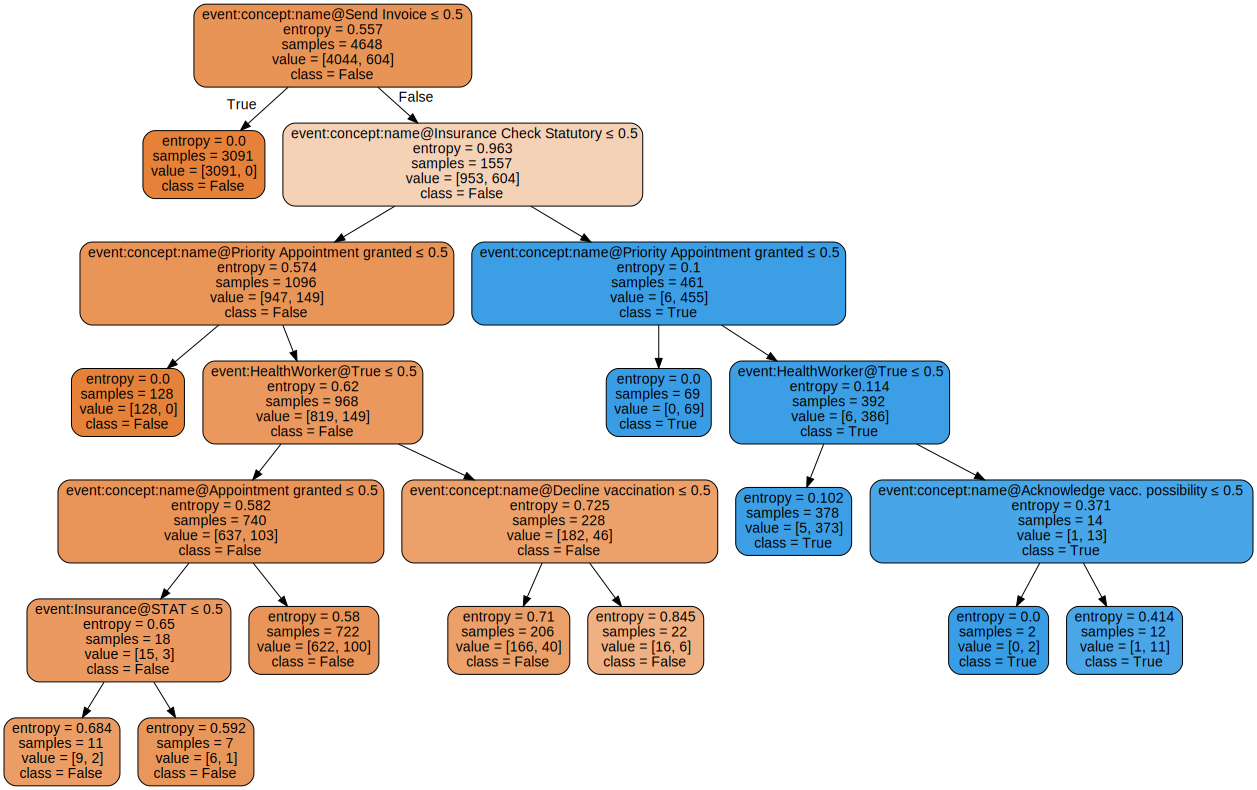

In [51]:
data, feature_names = log_to_features.apply(log_illegal, parameters={"str_ev_attr": ["concept:name", "Insurance", "HealthWorker"]})
target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_presence(log_illegal, "illegal", True)

clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(data, target)
gviz = dectree_visualizer.apply(clf, feature_names, classes)
gviz